# Heterogeneous Agents, Aiyagari (1994) economy

## Daniel Dimitrov

In [1]:
from scipy import optimize
import numpy as np

import numpy as np
import random #use to set seed
import matplotlib.pyplot as plt

In [2]:
def kstar_fn(kstar, *params):
    # steady state equilibrium value of agg. capital 
    beta, delta, alpha, u = params
    f = (1 - beta*(1 - delta)*(alpha*np.sign(kstar)*np.abs(kstar)**(alpha - 1))*(1 - u)**(1 - alpha) + (1 - alpha)*np.sign(kstar)*np.abs(kstar)**(alpha)*(1 - u)**(-alpha))/(beta*(1 - delta)**(2) - beta*(1 - delta) - (1 - delta) + 1) - kstar
    return f

def kbar_rbc(params):
    # use the representative agent model as an initial guess on kbar
    beta, delta, alpha, u = params
    f = (alpha*beta/(1 - beta*(1- delta)))**(1/(1 - alpha))
    return f

In [3]:
beta = 0.96
delta = 0.06
alpha = 0.36
u = 0.1
params = beta, delta, alpha, u
root = optimize.root(kstar_fn, 0.1, params)
kstar = root.x 
print(kstar)

[0.10389588]


In [26]:
#Value function iteration
def hetagents(kbar, params, N = 200):    
    #Set seed
    random.seed(0)
    #Unpack parameters
    beta, delta, alpha, u = params
    #set threshold
    threshold, eps = 1e-10, 10000
    #Set boundaries for k and set up grid
    k_low = 0.001
    k_high = 20
    kgrid = np.linspace(k_low, k_high, N)
    #Set up value function matrices
    V_old,V_new = np.zeros((2,N)), np.zeros((2,N))
    c = np.zeros_like(V_old)
    k_policy = np.zeros_like(V_old)
    #Set unemployment u 
    u = 0.1
    #Set transition matrix
    transition = np.array([[0.9, 0.1], [0.9, 0.1]])
    count, max_iter = 0, 500
    
    while (eps > threshold and count < max_iter):
        for i,k in enumerate(kgrid):
            #Compute r(kbar) and w(kbar)
            r = alpha*kbar**(alpha - 1)*(1 - u)**(1 - alpha)
            w = (1 - alpha)*kbar**(alpha)*(1 - u)**(-alpha)
            #Construct consumption for shocks
            c[0, :] = r*k + w*1 + (1 - delta)*k - kgrid # epsilon = 1
            c[1, :] = r*k + w*0 + (1 - delta)*k - kgrid # epsilon = 0 
            util = np.zeros_like(V_old)
            util[c <= 0] = -99999999 
            util[c > 0]= np.log(c[c > 0])
            V_choice = util + beta*(np.dot(transition, V_old))
            V_new[:, i] = np.amax(V_choice, axis = 1) 
            idx_policy = np.argmax(V_choice, axis = 1)
            k_policy[:, i] = kgrid[idx_policy]
            
        eps = np.linalg.norm(V_new - V_old,2)
        V_old = V_new.copy()
        count += 1
        
    return k_policy, V_new, kgrid
    


In [47]:
def pathSim(params, kbar, returnSim = False):
    
    #Set seed
    t = 10000 
    capital_series = np.zeros(t)
    tol, eps = 1e-4, 10000
    itr, max_iter = 0, 10000
    random.seed(0)
    
    k_policy, V_new, kgrid =  hetagents(kbar, params, 400)
    k = random.choice(kgrid)
    capital_series[0] = k

    for i in range(1, t):
        epsilon = np.random.binomial(1, 0.9, 1)
        if epsilon == 1:
            k = k_policy[0, np.where(kgrid == k)[0]]
        else:
            k = k_policy[1, np.where(kgrid == k)[0]]
        capital_series[i] = k
    kbar_new = np.mean(capital_series)
    eps  = (kbar_new - kbar)
    #print(kbar)
    kbar = kbar_new
    print('kbar',kbar,'eps',eps)
    itr  += 1
    print("Iteration:", str(itr), str(eps))
    if returnSim == True:
        return capital_series
      
    return eps

In [40]:
def bisection(f,a,b):
    '''Approximate solution of f(x)=0 on interval [a,b] by the bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> bisection(f,1,2,25)
    1.618033990263939
    >>> f = lambda x: (2*x - 1)*(x - 3)
    >>> bisection(f,0,1,10)
    0.5
    '''
    max_iter, count = 250, 0 
    eps, threshold =100, .5
    if f(a)*f(b) >= 0:
        print("Bisection method fails.")
        return None
    a_n = a
    b_n = b
    while (eps > threshold and count < max_iter): 
    #for n in range(1,N+1):
        m_n = (a_n + b_n)/2
        f_m_n = f(m_n)
        if f(a_n)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
        count +=1
        eps = b_n - a_n 
    return (a_n + b_n)/2

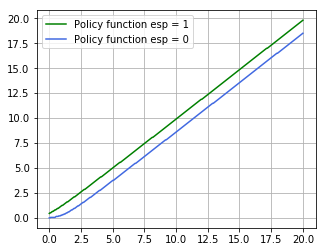

In [28]:
# Step 1:  guess on kbar (perhaps start with the 
#    value that obtains in a representative-agent economy in steady state)

kbar = kbar_rbc(params)

# Step 2:  iterate on the Bellman equation to find the value and policy functions

k_policy, V_new, kgrid = hetagents(kbar, params, 400)

plt.figure(figsize = (5, 4))
plt.plot(kgrid, k_policy[0, :], color = "g", label = "Policy function esp = 1")
plt.plot(kgrid, k_policy[1, :], color = "royalblue", label = "Policy function esp = 0")
plt.grid()
plt.legend()

In [41]:
# Step 3: simulate a long time series for a typical consumer using the
# optimal decision rule (computed in the second step) and the law of motion for epsilon

kbar_final = kbar_rbc(params)
f = lambda kbar: pathSim(params, kbar)

bisection(f,0.1,10)

kbar 19.998586536842105 eps 19.898586536842103
Iteration: 1 19.898586536842103
kbar 1.520041838596491 eps -8.479958161403509
Iteration: 1 -8.479958161403509
kbar 19.719983926315788 eps 14.669983926315787
Iteration: 1 14.669983926315787
kbar 19.998586536842105 eps 19.898586536842103
Iteration: 1 19.898586536842103
kbar 1.526878589473684 eps -8.473121410526316
Iteration: 1 -8.473121410526316
kbar 2.0711922245614036 eps -5.453807775438596
Iteration: 1 -5.453807775438596
kbar 19.718405057894735 eps 14.668405057894734
Iteration: 1 14.668405057894734
kbar 18.556954361403506 eps 12.269454361403506
Iteration: 1 12.269454361403506
kbar 19.714154643859647 eps 14.664154643859646
Iteration: 1 14.664154643859646
kbar 2.099882519298245 eps -5.425117480701756
Iteration: 1 -5.425117480701756
kbar 3.0172201087719297 eps -3.8890298912280703
Iteration: 1 -3.8890298912280703
kbar 18.617628019298245 eps 12.330128019298245
Iteration: 1 12.330128019298245
kbar 6.34842697368421 eps -0.24844802631579022
Iterat

6.442187499999999

kbar 2.2837279631578946 eps -4.927448429441612
Iteration: 1 -4.927448429441612


Text(0.5, 1.0, 'Histogram of Capital')

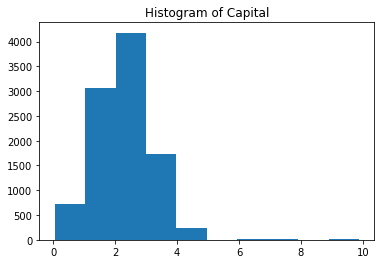

In [51]:
capitalSims = pathSim(params, kbar,True)
plt.hist(capitalSims)
plt.title('Histogram of Capital')